## Data links

sea ice (NOAA/NSIDC CDR v4): https://nsidc.org/data/g02202

SST (NOAA OI v2): https://psl.noaa.gov/data/gridded/data.noaa.oisst.v2.html

Chl (NOAA VIIRS via polarwatch): https://polarwatch.noaa.gov/catalog/chl-viirs-noaa-sq/preview/?dataset=monthly&var=chlor_a&time_min=2022-02-01T12:00:00Z&time_max=2022-02-01T12:00:00Z&proj=epsg3031&colorBar=KT_algae,,Log,0.001,10,

SOCCOM float 5906226 (retrieved from: https://www.mbari.org/science/upper-ocean-systems/chemical-sensor-group/soccom-float-visualization/). Alternative source w/ trajectory: https://fleetmonitoring.euro-argo.eu/float/5906226

Spatial ranges:
+ SST and Chl: 100W-0W, 75S-40S (for chl data, a stride of 5 was used for lat/lon)
+ sea ice: entire SO (no option to subselect pre-download)

Time ranges:
+ Chl: Jan 2012-Feb 2022, monthly
+ SST: Jan 1982-Feb 2022, monthly
+ SIE: 1978-Feb 2022, montly (including near-real time for 2022)

Note: This notebook generates separate figures for the chlorophyll map, historical SST, SIE, and Chl trends, and the SOCCOM float profiles. These figures are resized and arranged in Keynote to create figure 2 in our manuscript.

In [1]:
import numpy as np
from ftplib import FTP
import os
import xarray as xr
import matplotlib.pyplot as plt

from matplotlib.ticker import FormatStrFormatter
import cartopy.crs as ccrs 
import cartopy.feature 

from datetime import datetime, timedelta 
import matplotlib.dates as mdates
import calendar as cal
import pandas as pd

from scipy.stats import linregress
from scipy.interpolate import interp1d
import gsw
import seawater as sw

import xesmf as xe
import cmasher as cmr

In [2]:
plot_dir = 'plots_for_figure/'
fig_fmt = '.pdf' # alternatively '.png', '.jpg' (dpi=300)
os.makedirs(plot_dir, exist_ok=True)

In [3]:
# load data
data_dir = 'data/' # local directory (contains only the files needed for this notebook)
#data_dir = '../data/' # external directory (used for other purposes)

# SST
sst_fpath = os.path.join(data_dir, 'sst/noaa_sst_1982-2022_02_100W-0W_75S_40S.nc')
sst_ds = xr.open_dataset(sst_fpath)

# CDR v4 (sea ice conc.)
cdr_fpath = os.path.join(data_dir, 'sea_ice/merged_cdr_mon_seaice_conc_v4_ends_2021-12-01.nc')
cdr_ds = xr.open_dataset(cdr_fpath)
sic_v4 = cdr_ds['cdr_seaice_conc_monthly']

# CDR near-real-time
cdr_nrt_fpath = os.path.join(data_dir, 'sea_ice/merged_cdr_mon_seaice_conc_nrt_ends_2022-02-01.nc')
cdr_nrt_ds = xr.open_dataset(cdr_nrt_fpath)
cdr_nrt_ds
sic_nrt = cdr_nrt_ds['cdr_seaice_conc_monthly']

# merge v4 and nrt
sic_merged = xr.concat([sic_v4, sic_nrt], dim='tdim')
sic_dtimes = pd.to_datetime(sic_merged.time.values)

# soccom floats
float_nums = ['5906226'] # other options: '5906227',  '5905991'
data_dir = os.path.join(data_dir, 'soccom_floats/')
fnames0 = os.listdir(data_dir)
fnames = [fname for fname in fnames0 if fname.split('_')[0] in float_nums] # fname example: '5905991_Sprof.nc'
fpaths = [os.path.join(data_dir, fname) for fname in fnames if fname.endswith('prof.nc')]
soccom_ds_list = []
for fpath in fpaths:
    soccom_ds = xr.open_dataset(fpath)
    soccom_ds['dtimes'] = pd.to_datetime(soccom_ds['JULD'].values)
    soccom_ds_list.append(soccom_ds)
    
# data_dir = '../data/argo_floats/'
# fnames = os.listdir(data_dir)
# fpaths = [os.path.join(data_dir, fname) for fname in fnames if fname.endswith('.nc')]
# argo_ds_list = []
# for fpath in fpaths:
#     argo_ds = xr.open_dataset(fpath)
#     argo_ds['dtimes'] = pd.to_datetime(argo_ds['TIME'].values)
#     argo_ds_list.append(argo_ds)

/Users/ewilson2011/opt/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'cdr_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/Users/ewilson2011/opt/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_bt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,
/Users/ewilson2011/opt/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/xarray/conventions.py:500: SerializationWarning: variable 'nsidc_nt_seaice_conc_monthly' has _Unsigned attribute but is not of integer type. Ignoring attribute.
  decode_timedelta=decode_timedelta,


In [4]:
# load Chl
chl_data_dir = '../data/polarwatch/chla/'
chl_fnames = os.listdir(chl_data_dir)

ds_list = []
for fname in chl_fnames:
    if fname.endswith('stride5.nc'):
        chl_ds_ii = xr.open_dataset(os.path.join(chl_data_dir, fname))
        ds_list.append(chl_ds_ii.mean(dim='altitude'))

chl_ds_xx = xr.concat(ds_list, dim='time').sortby('time')
chl_ds = chl_ds_xx.rename(latitude='lat', longitude='lon')
chl_dtimes = pd.to_datetime(chl_ds.time.values)

chl = chl_ds['chlor_a']

In [5]:
# regrid SIC to SST coords
# convert coords to lat/lon
proj_epsg = cartopy.crs.epsg(3412)  # code obtained from cdr doc
proj_cart = ccrs.PlateCarree() 

XX_sic, YY_sic = np.meshgrid(sic_merged.xgrid.values, sic_merged.ygrid.values)
coords = proj_cart.transform_points(src_crs=proj_epsg, x=XX_sic, y=YY_sic)
sic_lons = coords[...,0]
sic_lats = coords[...,1]

# create a new data array
coords_dict = dict(lon=(["x", "y"], sic_lons), lat=(["x", "y"], sic_lats), time=sic_dtimes)
sic_merged_latlon = xr.DataArray(sic_merged.values, coords=coords_dict, dims=["time", "x", "y"])

da_out = xr.Dataset({ "lat": (["lat"], sst_ds.lat),"lon": (["lon"], sst_ds.lon)})
regridder = xe.Regridder(sic_merged_latlon, da_out, "bilinear", reuse_weights=True)
sic_merged_v2 = regridder(sic_merged_latlon)

Reuse existing file: bilinear_332x316_35x100.nc


/Users/ewilson2011/opt/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/xesmf/backend.py:36: UserWarning: Input array is not F_CONTIGUOUS. Will affect performance.
  warnings.warn("Input array is not F_CONTIGUOUS. "
/Users/ewilson2011/opt/anaconda3/envs/xesmf_env/lib/python3.7/site-packages/xesmf/frontend.py:421: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  keep_attrs=keep_attrs


In [6]:
# get monthly anomalies (SST)
clim_ref = [datetime(1982,1,1), datetime(2020,12,1)]
sst_dtimes = pd.to_datetime(sst_ds['time'].values)
sst_clim = sst_ds['sst'].isel(time=np.logical_and(sst_dtimes>=clim_ref[0], 
                                           sst_dtimes<=clim_ref[-1])).groupby('time.month').mean('time')

sst_anom = sst_ds['sst'].groupby('time.month') - sst_clim

In [7]:
sic_clim = sic_merged_v2.isel(time=np.logical_and(sic_dtimes>=clim_ref[0], 
                                        sic_dtimes<=clim_ref[-1])).groupby('time.month').mean('time')

sic_anom = sic_merged_v2.groupby('time.month') - sic_clim 

In [8]:
chl_clim = chl.isel(time=np.logical_and(chl_dtimes>=clim_ref[0], 
                                        chl_dtimes<=clim_ref[-1])).groupby('time.month').mean('time')

chl_anom = chl.groupby('time.month') - chl_clim

In [9]:
def generate_area_map(figsize=(8, 8), rows_cols=[1, 1], extent=[-80, -20, -70, -40], lcol=0.3, fz=12):

    
    central_lon, central_lat = extent[0]+(extent[1]-extent[0])/2, extent[2]+(extent[3]-extent[2])/2
    

    #fig, axes = plt.subplots(*rows_cols, figsize=figsize, projection=ccrs.Orthographic(central_lon, central_lat))
    fig, axes = plt.subplots(*rows_cols, figsize=figsize, 
                             subplot_kw={'projection': ccrs.Orthographic(central_lon, central_lat)})
    
    if np.max(rows_cols)==1:
        axes = [axes]
        
    for ax in axes:
        ax.set_extent(extent)
        #ax.gridlines()
        ax.coastlines() #resolution='50m'
        ax.add_feature(cartopy.feature.LAND, zorder=100, edgecolor='k')

        glines = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                              linewidth=2, color='gray', alpha=0.5, linestyle='--')

        glines.xlabels_left = False
        glines.xlabels_right = False
        glines.right_labels = False
        glines.top_labels = False

        glines.xlabel_style = {'size': fz}
        glines.ylabel_style = {'size': fz}

        #glines.ylabels_left = False
    
    return axes


def convert_dms_dec(deg, mins=0, secs=0): 
    dec = (deg + mins/60 + secs/(60*60))
    
    return dec 

In [10]:
#-------define some helper functions

In [11]:
def generate_panel_map(data_dict, add_ship_track=True, add_soccom_tracks=True, add_argo_tracks=True,
                       add_sic=True, focus_box_size = [5, 10], 
                       add_focus_box=True, save_plot=False, time_avg=False, line_col_update={},
                       map_vble='sst_anom',  fz = 8, leg_fz=6, cmap='', leg_loc=0, fig_size=(15, 4),
                       fig_fmt=fig_fmt,
                       tr=np.array([datetime(2021, 11, 1), datetime(2022, 1, 15)])):

    #------unpack some stuff
    map_dtimes = data_dict['%s_dtimes'%map_vble]
    clvls = data_dict['%s_clvls'%map_vble]
    map_data = data_dict[map_vble]
        
    #------limit to focus time range
    ti = np.logical_and(map_dtimes>=tr.min(), map_dtimes<=tr.max())
    dtimes_sub = map_dtimes[ti]

    #-----update line colors 
    line_cols = {'sic_clim': 'k', 'sic_mon': 'magenta', 'ship': 'green', 
                 'soccom_float': 'cyan', 'argo_float': 'teal', 'region_box': 'k'}
    
    show_line_cols = True
    for key in line_col_update:
        if key in line_cols:
            line_cols[key] = line_col_update[key]
        else:
            print('%s is not valid. See color entries below:' %key)
            if show_line_cols:
                print(line_cols)
                show_line_cols = False
                
    #------set colormap for background data 
    if cmap=='':
        cmap = data_dict['%s_cmap'%map_vble]
            

    #------generate regional map(s)
    if time_avg:
        map_data_mean = map_data.isel(time=ti).mean(dim='time')
        axes = generate_area_map(figsize=fig_size, rows_cols=[1, 1], 
                                 extent=[-70, -30, -70, -50], fz=fz)
    else:    
        axes = generate_area_map(figsize=fig_size, rows_cols=[1, len(dtimes_sub)], 
                                 extent=[-70, -30, -70, -50], fz=fz)

    
    #------define outline for focus region
    ship_coords = data_dict['ship_coords']
    ship_coords_mean = np.array(ship_coords).mean(axis=0)
    minlat, maxlat = ship_coords_mean[0]-focus_box_size[0], ship_coords_mean[0]+focus_box_size[0]
    minlon, maxlon = ship_coords_mean[1]-focus_box_size[1], ship_coords_mean[1]+focus_box_size[1]

    verts = np.array([[minlon, maxlat], [minlon, minlat], 
                      [maxlon, minlat], [maxlon, maxlat], 
                      [minlon, maxlat]])

    #-----interpolate longitudinal line sections to higher resolution
    vert_lats = verts[:, 1]
    vert_lons = verts[:, 0]
    vert_lats_hires = np.array([])
    vert_lons_hires = np.array([])
    for kk in range(len(vert_lats)-1):
        vert_lats_hires = np.append(vert_lats_hires, np.linspace(vert_lats[kk], vert_lats[kk+1], 50))
        vert_lons_hires = np.append(vert_lons_hires, np.linspace(vert_lons[kk], vert_lons[kk+1], 50))

    focus_box = np.vstack([vert_lons_hires, vert_lats_hires]).T
    
    
    #-----misc definitions
    XX, YY = np.meshgrid(map_data.lon, map_data.lat)
    sie_str = ''
    markers = ['o', 's', '>', '^', '+', 'd'] # for float tracks
    ms = 5
    mean_ship_coords = ship_coords.mean(axis=0)

    #-------generate plot for each axis
    for ii, ax in enumerate(axes):

        plt.sca(axes[ii])

        #-----add background surface data 
        # Two options: plot average for time range or make map for each month
        if time_avg:
            map_tt = map_data_mean
            time_str = "%s-%s"%(tr[0].strftime("%b-%Y"), tr[-1].strftime("%b-%Y"))                   
        else:
            map_tt = map_data.sel(time=dtimes_sub[ii], method='nearest').values
        
        im = ax.contourf(XX, YY, map_tt, clvls, vmin=clvls.min(), vmax=clvls.max(), 
                         cmap=cmap, extend='both', transform=ccrs.PlateCarree())


        #-------add ship track
        if add_ship_track:
            ship_col = line_cols['ship']
            ax.plot(ship_coords[:, 1], ship_coords[:, 0], '-o', color=ship_col, transform=ccrs.PlateCarree(),
                   label='ship track')
        
        #-------add soccom float track
        
        
        if add_soccom_tracks:
            
            for jj, float_ds in enumerate(data_dict['soccom_ds_list']):
                float_num = float_ds['PLATFORM_NUMBER'].values[0].decode("utf-8").strip()
                float_col = line_cols['soccom_float']
                float_dtimes = pd.to_datetime(float_ds['JULD'].values)
                
                float_tsel = np.logical_and(float_dtimes>=tr[0], float_dtimes<=tr[1])
                
                if len(float_ds['LONGITUDE'][float_tsel])==0:
                    continue
                
                min_lat, max_lat = float_ds['LATITUDE'][float_tsel].min(),float_ds['LATITUDE'][float_tsel].max()
                min_lon, max_lon = float_ds['LONGITUDE'][float_tsel].min(),float_ds['LONGITUDE'][float_tsel].max()
                
                # only plot float if it cross focus box
                near_ship_lat = np.logical_and(min_lat<mean_ship_coords[0]+focus_box_size[0],
                                               max_lat>mean_ship_coords[0]-focus_box_size[0])
                near_ship_lon = np.logical_and(min_lon<mean_ship_coords[1]+focus_box_size[1],
                                               max_lon>mean_ship_coords[1]-focus_box_size[1])    
                
                near_ship = np.logical_and(near_ship_lat, near_ship_lon)                               
                
                if near_ship:
                    ax.plot(float_ds['LONGITUDE'][float_tsel], float_ds['LATITUDE'][float_tsel], '-', 
                            marker=markers[jj], color=float_col, transform=ccrs.PlateCarree(), 
                            label='SOCCOM float %s'%float_num, ms=ms, lw=1 )
                else:
                    print("Warning: float %s did not enter focus box" %float_num)

        # ------add sea ice extent clim
        if add_sic:
            
            sie_str = '_sie' # used for generating figure filename
            
            if time_avg:
                idx = -1 # plot the last month (Note: should make this a time average to be consistent)
            else:
                idx = ii
                
            sic_lw = 3
            sic = data_dict['sic']
            # clean up SIC artifacts near scotia islands
            lat_mask = np.logical_and(data_dict['sic'].lat>-57, data_dict['sic'].lon<340)==False 
            sic_clim_map = data_dict['sic_clim'].sel(month=dtimes_sub[idx].month)
            
            # make plots
            col1 = line_cols['sic_clim']
            col2 = line_cols['sic_mon']
            CS1 = ax.contour(sic.lon, sic.lat, sic_clim_map.where(lat_mask), [20], 
                       colors=col1, linestyles='--',transform=ccrs.PlateCarree(), linewidths=sic_lw)

            CS2 = ax.contour(data_dict['sic'].lon, data_dict['sic'].lat, 
                             data_dict['sic'].sel(time=dtimes_sub[idx], method='nearest').where(lat_mask), [20], 
                             colors=col2, transform=ccrs.PlateCarree(), linewidths=sic_lw)

            #  collect line handles for legend
            labels = [dtimes_sub[idx].strftime("SIE (%b climatology)")]
            for i in range(len(labels)):
                CS1.collections[i].set_label(labels[i])

            labels = [dtimes_sub[idx].strftime("SIE (%b-%Y)")]
            for i in range(len(labels)):
                CS2.collections[i].set_label(labels[i])

        #------- add focus box
        if add_focus_box:
            ax.plot(focus_box[:, 0], focus_box[:, 1], ':', color=line_cols['region_box'], lw=2, 
                    transform=ccrs.Geodetic())
        
        #-----add legend
        leg = plt.legend(loc=leg_loc, fontsize=leg_fz, framealpha=1, ncol=2) 
        leg.get_frame().set_facecolor('0.1')
        plt.setp(leg.get_texts(), color='w')

        

    #-------add figure colorbar
    cb_ax = plt.gcf().add_axes([0.93, 0.23, 0.02, 0.55])
    cbar = plt.colorbar(im, cax=cb_ax, extend='max')
    cbar.set_ticks(clvls[::4])
    cbar.ax.set_ylabel(data_dict['%s_label'%map_vble], fontsize=fz)
    cbar.ax.tick_params(labelsize=fz) 
    cbar.solids.set_edgecolor("face")
    
    #-------save figure
    if save_plot:
        time_str = "%s_%s"%(tr[0].strftime("%b-%Y"), tr[-1].strftime("%b-%Y") )
        plt.savefig(os.path.join(plot_dir, '%s_%s%s%s'%(map_vble, time_str, sie_str, fig_fmt)), bbox_inches='tight')
        
    return focus_box

In [25]:
# from paper: #60o 24.44'S, 46o 04.45'W to 60o 18.29'S, 45o 53.51'W
ship_coords = [[convert_dms_dec(-60, -24.33, 0), convert_dms_dec(-46, -4.45)]]
ship_coords.append([convert_dms_dec(-60, -18.29, 0), convert_dms_dec(-45, -53.51)])
ship_coords = np.array(ship_coords)
ship_coords

array([[-60.4055    , -46.07416667],
       [-60.30483333, -45.89183333]])

In [13]:
# consolidate data 
data_dict = {}

data_dict['sst'] = sst_ds['sst']
data_dict['sst_anom'] = sst_anom
data_dict['sst_clim'] = sst_clim
data_dict['sst_anom_dtimes'] = sst_dtimes
data_dict['sst_dtimes'] = sst_dtimes
data_dict['sst_anom_clvls']  = np.arange(-1.6, 1.6001, 0.1)
data_dict['sst_anom_cmap'] = 'coolwarm'
data_dict['sst_anom_label'] = "SST anomaly ($^{\circ}$C)"
data_dict['sst_label'] = "SST ($^{\circ}$C)"

data_dict['chl'] = chl
data_dict['chl_clim'] = chl_clim
data_dict['chl_dtimes'] = chl_dtimes
data_dict['chl_clvls']  = np.arange(0.2, 1.601, 0.05)
data_dict['chl_cmap'] = 'viridis'
data_dict['chl_label'] = "Chlorophyll-a (mg/m$^3$)"

data_dict['sic'] = 100*sic_merged_v2
data_dict['sic_clim'] = 100*sic_clim
data_dict['sic_dtimes'] = sic_dtimes
data_dict['sic_label'] = "SIC (%)"

#data_dict['float_dtimes'] = float_dtimes
data_dict['soccom_ds_list'] = soccom_ds_list
#data_dict['argo_ds_list'] = argo_ds_list
data_dict['ship_coords'] = ship_coords

In [14]:
float_lats = soccom_ds_list[0].LATITUDE
float_lons = soccom_ds_list[0].LONGITUDE
float_dtimes = pd.to_datetime(soccom_ds_list[0]['JULD'].values)

mean_ship_loc = ship_coords.mean(axis=0)

# compute distance between float and ship
dist = []

for ii in range(len(float_lats)):
    dd = sw.dist([mean_ship_loc[0], float_lats[ii]], [mean_ship_loc[1], float_lons[ii]])[0][0]
    dist.append(dd)
    time_str = float_dtimes[ii].strftime("%B %d, %Y")
    #print("Time: %s, lat: %.2f, lon: %.2f, distance: %.2f" %(time_str, float_lats[ii], float_lons[ii], dd))
    
dist = np.array(dist)
print("Mean ship location: %.2f lat, %.2f lon" %(mean_ship_loc[0], mean_ship_loc[1]))
print("Min distance between float and ship %.2f km" %dist.min())

Mean ship location: -59.64 lat, -45.02 lon
Min distance between float and ship 188.34 km


## Generate monthly mean maps of SST, SIE, and Chl

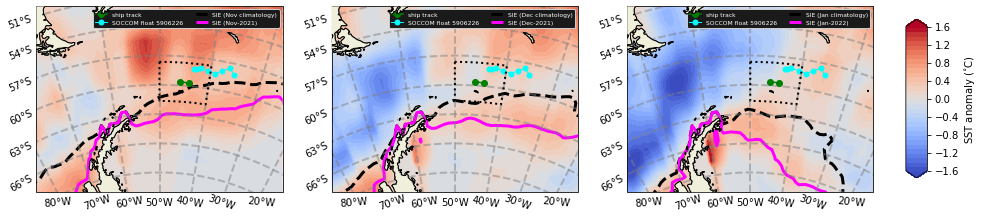

In [15]:
_ = generate_panel_map(data_dict, add_ship_track=True, add_soccom_tracks=True, add_sic=True,
                       add_focus_box=True, save_plot=False, focus_box_size = [2, 5],
                       map_vble='sst_anom',  fz = 10, leg_loc=1,
                       tr=np.array([datetime(2021, 11, 1), datetime(2022, 1, 15)]))

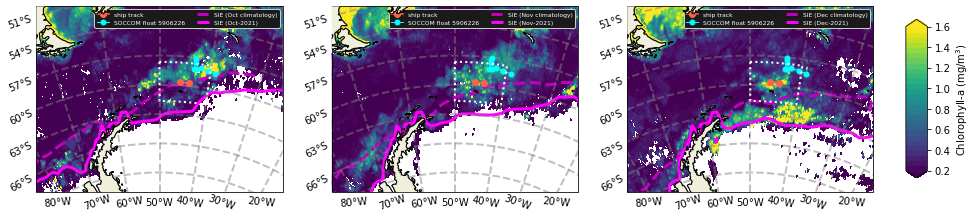

In [24]:
# note: this can take up to a minute to run (comment below)
line_col_update = {'sic_clim':'m',  'region_box': 'w', 'soccom_float': 'cyan', 'argo_float': '0.8',
                   'ship': 'tomato'}
_ = generate_panel_map(data_dict, add_ship_track=True, add_soccom_tracks=True, add_argo_tracks=False, add_sic=True,
                       add_focus_box=True, save_plot=False, line_col_update=line_col_update,
                       map_vble='chl',  fz = 10, leg_loc=1, leg_fz=6, focus_box_size = [2, 5],
                       tr=np.array([datetime(2021, 10, 1), datetime(2021, 12, 15)]))

In [17]:
# line_col_update = {'sic_clim':'m', 'region_box': 'tomato', 'float': 'lightblue', 'ship': 'r'}
# generate_panel_map(data_dict, add_ship_track=True, add_float_track=True, add_sic=True,
#                        add_sample_box=True, save_plot=False, leg_loc=4,
#                        map_vble='chl',  fz = 8, line_col_update = line_col_update,
#                        tr=np.array([datetime(2021, 11, 1), datetime(2022, 1, 15)]))

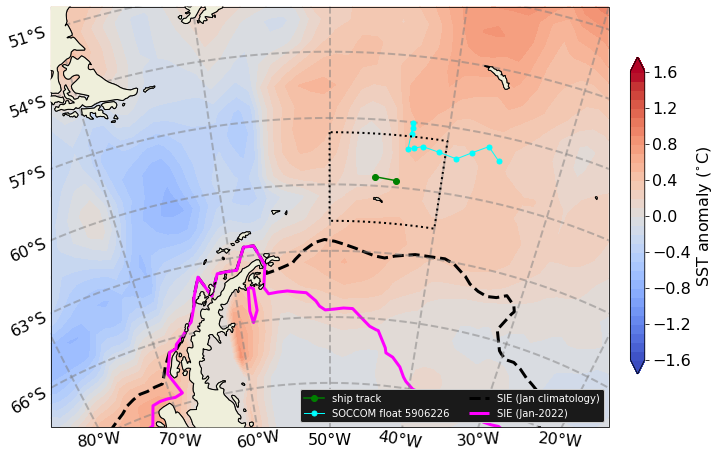

In [18]:
focus_box= generate_panel_map(data_dict, add_ship_track=True, add_soccom_tracks=True, add_sic=True,
                       add_focus_box=True, save_plot=False, time_avg=True, focus_box_size=[2, 5],
                       map_vble='sst_anom',  fz =16, leg_fz=10, leg_loc=4, fig_size=(10, 8),
                       tr=np.array([datetime(2021, 10, 1), datetime(2022, 1, 15)]))

In [19]:
#debug

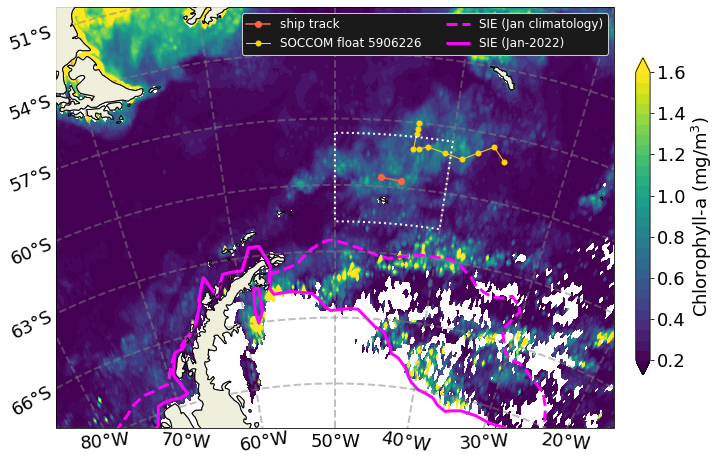

In [20]:
line_col_update = {'sic_clim':'magenta', 'sic_mon':'magenta', 
                   'region_box': 'w', 'soccom_float': 'gold', 'argo_float': '0.8',
                   'ship': 'tomato'}
focus_box = generate_panel_map(data_dict, add_ship_track=True, add_soccom_tracks=True, add_sic=True,
                       add_focus_box=True, save_plot=True, time_avg=True, line_col_update=line_col_update,
                       map_vble='chl', fz=18, leg_fz=12, leg_loc=1, fig_size=(10, 8), focus_box_size=[2, 5],
                       tr=np.array([datetime(2021, 10, 1), datetime(2022, 1, 15)]))

## Plot temporal variability of focus box

<xarray.DataArray 'sst' (time: 12)>
array([ 1.392     ,  2.074     ,  1.234     ,  0.7742499 ,  0.36049998,
       -0.1435    , -0.90524995, -1.1445    , -1.1987499 , -0.7975    ,
       -0.41574997,  0.08724999], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 1982-12-01


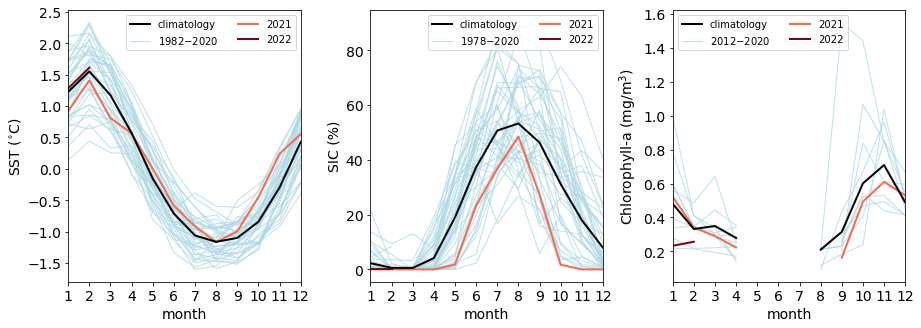

In [21]:
ship_coords_mean = np.array(data_dict['ship_coords']).mean(axis=0)
minlat, maxlat = ship_coords_mean[0]-2, ship_coords_mean[0]+2
minlon, maxlon = ship_coords_mean[1]-4, ship_coords_mean[1]+4

focus_box_lons360 = focus_box[:, 0]%360
years = np.arange(1982, 2023) # don't hardcode
mons = np.arange(1, 13)

focus_years = [2021, 2022]
focus_cols = cmr.get_sub_cmap('Reds', 0.5, 0.95, N=len(focus_years))

vnames = ['sst', 'sic', 'chl']
fz=14

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for ii, ax in enumerate(axes):
    
    # get variable
    vble = data_dict[vnames[ii]]
    vble_clim = data_dict['%s_clim'%vnames[ii]]
    
    # compute box mean
    latr = np.logical_and(vble.lat>=focus_box[:, 1].min(), vble.lat<=focus_box[:, 1].max())
    if np.max(vble.lon)<=180:
        lonr = np.logical_and(vble.lon>=focus_box[:, 0].min(), vble.lon<=focus_box[:, 0].max())
    else:
        lonr = np.logical_and(vble.lon>=focus_box_lons360.min(), vble.lon<=focus_box_lons360.max())
        
        
    box_sel = np.logical_and(latr, lonr)
    boxmean = vble.where(box_sel).mean(dim=['lat', 'lon'])
    boxmean_clim = vble_clim.where(box_sel).mean(dim=['lat', 'lon'])
    
    # plot climatology
    ax.plot(mons, boxmean_clim, lw=2, color='k', label='climatology', zorder=100)
    ax.set_ylabel(data_dict['%s_label'%vnames[ii]], fontsize=fz)
    
    # plot yearly ann cycle
    years_ii = np.array([dt.year for dt in data_dict["%s_dtimes"%vnames[ii]]])
    years_unique = np.unique(years_ii)
    
    kk = 0
    
    for jj, yr in enumerate(years_unique):

        tsel = years_ii==yr
        boxmean_yr = boxmean.isel(time=tsel)
        
        if ii==0 and jj==0:
            print(boxmean_yr)

        if yr in focus_years:
            col=focus_cols(kk)
            lw=2
            kk +=1
            ax.plot(mons[:len(boxmean_yr)], boxmean_yr, lw=lw, color=col, label=yr)

        else:
            col= 'lightblue' #'0.3'
            lw=1
            alpha=0.8

            if jj==0:
                ax.plot(mons[:len(boxmean_yr)], boxmean_yr, lw=lw, color=col,
                             alpha=alpha, label='%s$-$%s' %(years_ii[0], focus_years[0]-1))
            else:
                ax.plot(mons[:len(boxmean_yr)], boxmean_yr, lw=lw, color=col, alpha=alpha)
            
    
    # apply some formatting
    plt.sca(ax)
    #plt.grid(True) 
    plt.legend(loc=0, fontsize=fz-4, ncol=2)
    ax.tick_params(labelsize=fz) 
    plt.xticks(mons)
    plt.xlim(1, 12)
    plt.xlabel('month', fontsize=fz)
    
plt.subplots_adjust(wspace=0.3)
plt.savefig(os.path.join(plot_dir, 'box_mean_sie_sic_chl.pdf'), bbox_inches='tight')

## Plot argo profiles

In [22]:
# compute potential temperature
ptemp = sw.ptmp(soccom_ds['PSAL_ADJUSTED'], soccom_ds['TEMP_ADJUSTED'],
                                        soccom_ds['PRES_ADJUSTED'])
soccom_ds['POT_TEMP_ADJUSTED'] = xr.DataArray(ptemp, dims=['N_PROF', 'N_LEVELS'])

5906226


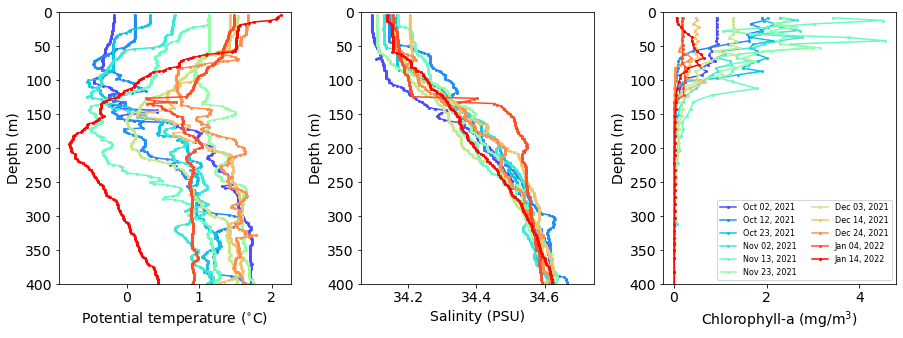

In [23]:
soccom_ds = soccom_ds_list[0]
float_num = soccom_ds['PLATFORM_NUMBER'].values[0].decode("utf-8").strip()
print(float_num)
float_dtimes = pd.to_datetime(soccom_ds['JULD'].values)
tr = [datetime(2021, 10, 1), datetime(2022, 1, 15)]
tsel = np.logical_and(float_dtimes>=tr[0], float_dtimes<=tr[1])

new_pres = np.linspace(10, 1000, 200)

fz = 14
vnames = ['POT_TEMP_ADJUSTED', 'PSAL_ADJUSTED',  'CHLA_ADJUSTED'] #'DOXY_ADJUSTED',
vnames_dict = {'POT_TEMP_ADJUSTED': 'Potential temperature', 'PSAL_ADJUSTED': 'Salinity', 'CHLA_ADJUSTED': 'Chlorophyll-a'}
units_dict = {'POT_TEMP_ADJUSTED': '$^{\circ}$C', 'PSAL_ADJUSTED': 'PSU', 'CHLA_ADJUSTED': 'mg/m$^3$'}
ms=2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for ii, ax in enumerate(axes):
    plt.sca(ax)
    vble_sub = soccom_ds[vnames[ii]][tsel, :]
    pres_sub = soccom_ds['PRES_ADJUSTED'][tsel, :]
    nprof = pres_sub.shape[0]
    dtimes_sub = float_dtimes[tsel]
    #units = soccom_ds[vnames[ii]].units 
    cols = cmr.get_sub_cmap('rainbow', 0.1, 0.99, N=nprof)
        
        
    for jj in range(nprof):
        time_str = dtimes_sub[jj].strftime("%b %d, %Y")
        no_val = np.isnan(vble_sub[jj, :])
        vble_jj = vble_sub[jj, :].dropna("N_LEVELS")
        
        plt.plot(vble_jj, pres_sub[jj,:][no_val==False], '-o', ms=ms, label=time_str, color=cols(jj))
        
#         if jj<5 and ii==2:
#             print(soccom_ds['DOXY_ADJUSTED'][10, :10].values)
#             print(soccom_ds['PRES_ADJUSTED'][10, :10].values)
#             pass
            
        
    
    plt.ylabel("Depth (m)", fontsize=fz)
    plt.xlabel("%s (%s)" %(vnames_dict[vnames[ii]], units_dict[vnames[ii]]), fontsize=fz)
    plt.ylim(400, 0)
    ax.tick_params(labelsize=fz) 
    
    if vnames[ii]=='CHLA_ADJUSTED':
        plt.legend(ncol=2, fontsize=fz-6)
        
plt.subplots_adjust(hspace=0.3, wspace=0.3)
#plt.suptitle("Float %s" %float_num, y=0.91, fontsize=fz+2)
plt.savefig(os.path.join(plot_dir, 'prof%s_temp_sal_chl.pdf'%float_num), bbox_inches='tight')